In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import abc_load as abc
get_ipython().run_line_magic('matplotlib', 'inline') 

In [3]:
adata = ad.read_zarr("/root/capsule/data/nsf_2000_adata1/nsf_2000_adata.zarr")

In [4]:
obs = adata.obs

section_col = 'z_section'
sections_all = sorted(obs[section_col].unique())
# pick 3 example sections
sections_3 = [6.4, 7.2, 8.0]

## distance metrics

In [5]:
import sklearn.metrics
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch

In [6]:
# factor totals correlated with gene totals??
np.corrcoef(obs['nsf_tot'].values, adata.X.sum(axis=1).squeeze())

array([[1.        , 0.08237784],
       [0.08237784, 1.        ]])

In [7]:
nsf_cols = [f"nsf{i}" for i in range(30)]
# un-normalized by scaling by totals?
factors = obs[nsf_cols].values * obs['nsf_tot'].values[:,None]
y = ssd.pdist(factors.T, metric='correlation')


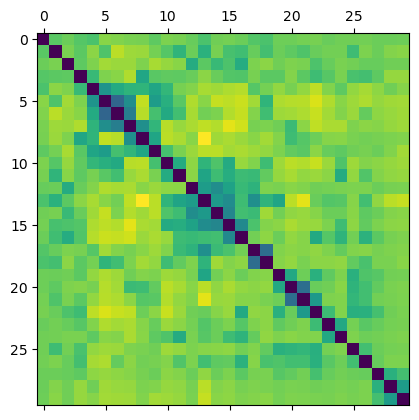

In [8]:
link = sch.linkage(y, method='single', optimal_ordering=True)
dend = sch.dendrogram(link, no_plot=True)
dist = ssd.squareform(y)
nsf_order = dend["leaves"]
dist = dist[nsf_order, :]
dist = dist[:, nsf_order]
plt.matshow(dist)

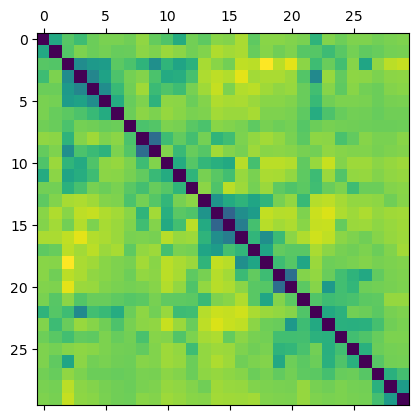

In [9]:
link = sch.linkage(y, method='complete', optimal_ordering=True)
dend = sch.dendrogram(link, no_plot=True)
dist = ssd.squareform(y)
order = dend["leaves"]
dist = dist[order, :]
dist = dist[:, order]
plt.matshow(dist)

In [10]:
th_names = abc.get_thalamus_substructure_names()
th_subregion_names = list(set(th_names).difference(['TH-unassigned']))

In [11]:
ccf_label = 'parcellation_substructure_realigned'
obs[ccf_label] = obs[ccf_label].str.replace('-unassigned','')

for x in th_subregion_names:
    obs[x] = obs[ccf_label] == x

In [12]:
th_subregions_found = list(set(th_subregion_names).intersection(obs[ccf_label].unique()))
obs[th_subregion_names].mean(axis=0).loc[lambda x: x==0]

PP    0.0
dtype: float64

<Axes: >

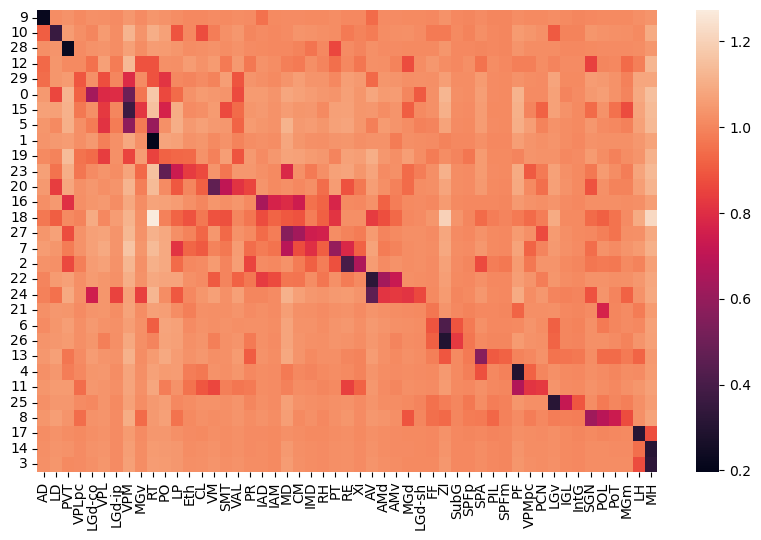

In [13]:
# TODO: lookup sort from cross-species alignment
regions = obs[th_subregions_found].values
# ssd.squareform(ssd.pdist())
dist_nsf_ccf = sklearn.metrics.pairwise_distances(factors.T[nsf_order], regions.T, metric='correlation')

min_dist = dist_nsf_ccf.min(axis=0)
ccf_sort = np.argsort(dist_nsf_ccf.argmin(axis=0) + min_dist)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(dist_nsf_ccf[:,ccf_sort], yticklabels=nsf_order, xticklabels=np.array(th_subregions_found)[ccf_sort], ax=ax)

In [14]:
# TODO: try clustering ccf on gene-space similarity (or spatial?) to order instead (sns.clustermap?)

## plotting

In [15]:
ccf_polygons = abc.get_ccf_labels_image(resampled=True, realigned=True)
# erase right hemisphere
ccf_polygons[550:,:,:] = 0
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_polygons, distance_px=1, fill_val=0, return_edges=True)

In [16]:

ccf_label = 'parcellation_substructure_realigned'

x_coord_col = 'x_section'
y_coord_col = 'y_section'


In [17]:
n=23


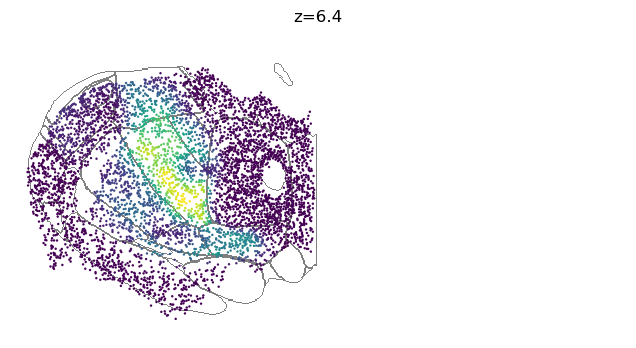

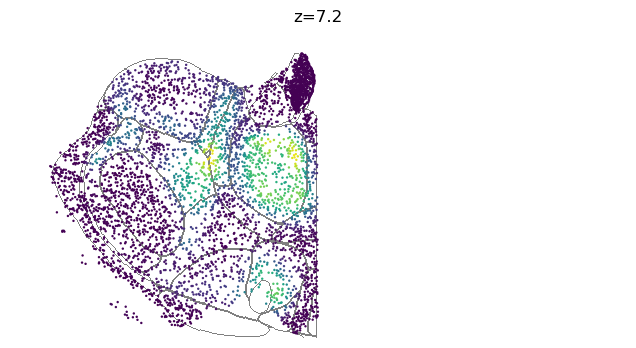

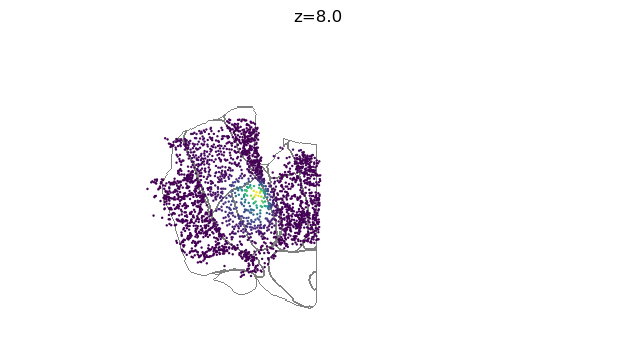

In [18]:

cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}', sections=sections_3,
                        shape_palette='dark_outline', 
                        point_palette='viridis', legend=None, 
                        section_col=section_col, 
                        x_col=x_coord_col, y_col=y_coord_col, s=3,
                        boundary_img=ccf_boundaries);

## gene plots from loadings

Caution: Do not always look like factors!

In [19]:
from importlib import reload
reload(cplots)

<module 'ccf_plots' from '/root/capsule/code/ccf_plots.py'>

In [20]:
loadings = adata.var[nsf_cols].to_numpy()
lin_weights = loadings @ np.linalg.pinv(loadings.T @ loadings)
# feat @ loadings.T = X, so feat ~= X @ lin_weights
adata.obsm['genes_on_loadings'] = adata.X @ loadings
adata.obsm['genes_linear_projection'] = adata.X @ lin_weights

In [21]:
# can't plot with obsm currently

# cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
#                         point_hue=adata.obsm['genes_on_loadings'][:,0], 
#                         sections=sections_3,
#                         shape_palette='dark_outline', 
#                         point_palette='viridis', legend=None, 
#                         section_col=section_col, 
#                         x_col=x_coord_col, y_col=y_coord_col, s=3,
#                         boundary_img=ccf_boundaries);

In [22]:
# TODO: try linear approx of forward transform
for i, x in enumerate(nsf_cols):
    loadings = adata.var[x].to_numpy()
    obs[x+"_allgenes"] = adata.X @ loadings
    order = loadings.argsort()
    loadings[order[:-3]] = 0
    obs[x+"_3genes"] = adata.X @ loadings
    loadings[order[:-2]] = 0
    obs[x+"_2genes"] = adata.X @ loadings
    obs[x+"_linear_genes"] = adata.X @ lin_weights[:,i]


/tmp/ipykernel_28439/234706736.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs[x+"_2genes"] = adata.X @ loadings
/tmp/ipykernel_28439/234706736.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs[x+"_linear_genes"] = adata.X @ lin_weights[:,i]
/tmp/ipykernel_28439/234706736.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

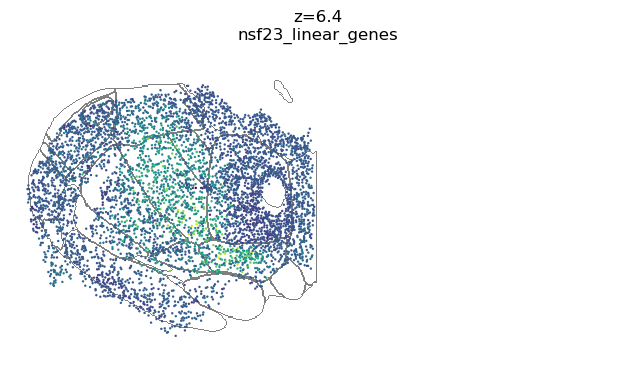

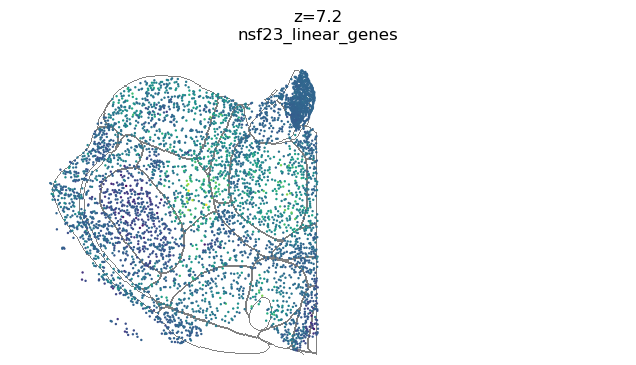

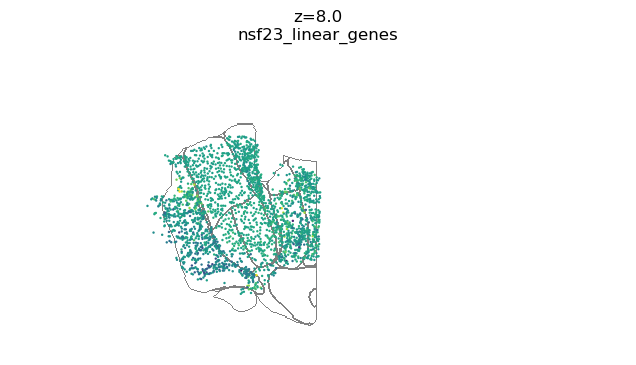

In [23]:
cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}_linear_genes', sections=sections_3,
                        shape_palette='dark_outline', 
                        point_palette='viridis', legend=None, 
                        section_col=section_col, 
                        x_col=x_coord_col, y_col=y_coord_col, s=3,
                        boundary_img=ccf_boundaries);

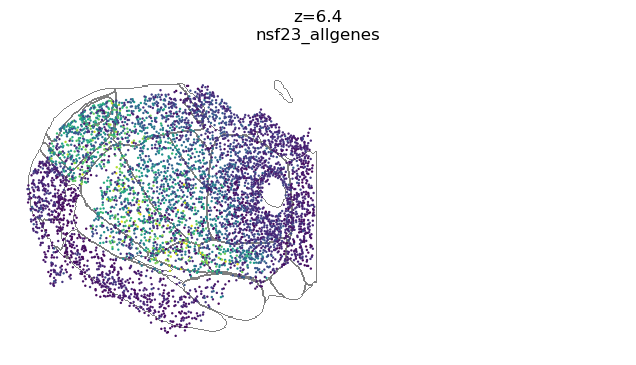

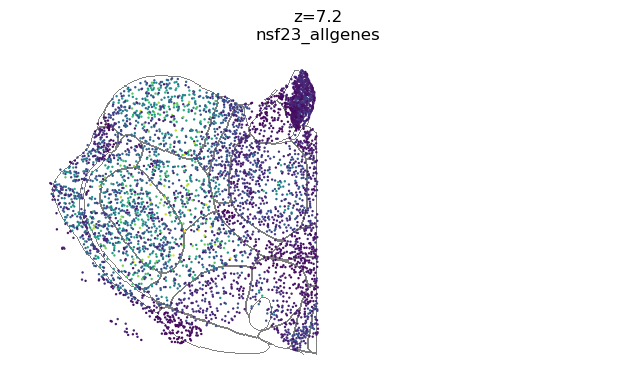

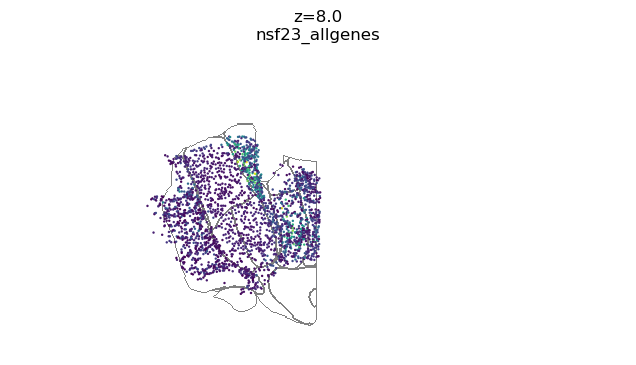

In [24]:
cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}_allgenes', sections=sections_3,
                        shape_palette='dark_outline', 
                        point_palette='viridis', legend=None, 
                        section_col=section_col, 
                        x_col=x_coord_col, y_col=y_coord_col, s=3,
                        boundary_img=ccf_boundaries);

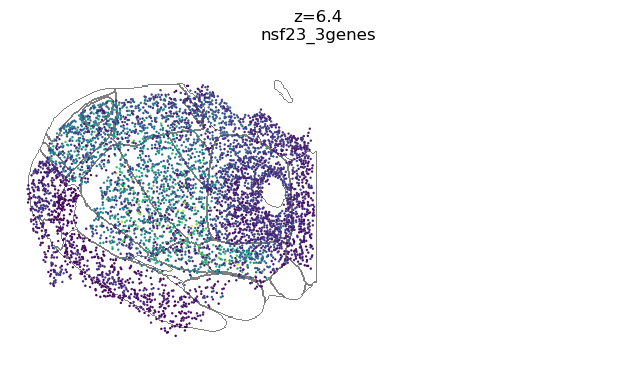

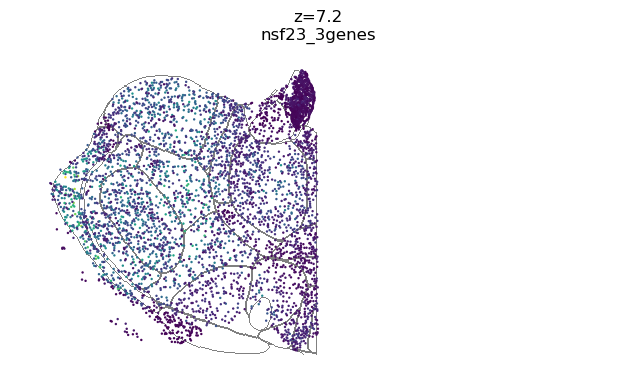

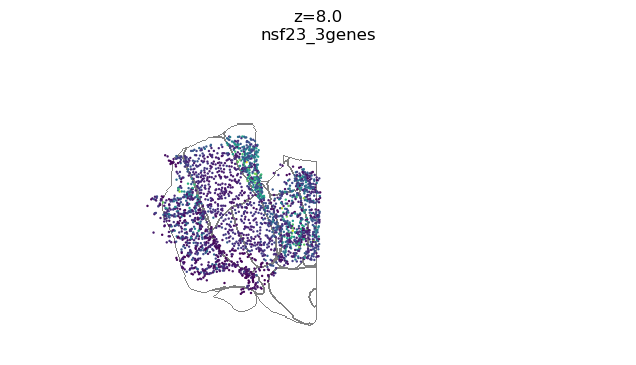

In [25]:
cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}_3genes', sections=sections_3,
                        shape_palette='dark_outline', 
                        point_palette='viridis', legend=None, 
                        section_col=section_col, 
                        x_col=x_coord_col, y_col=y_coord_col, s=3,
                        boundary_img=ccf_boundaries);

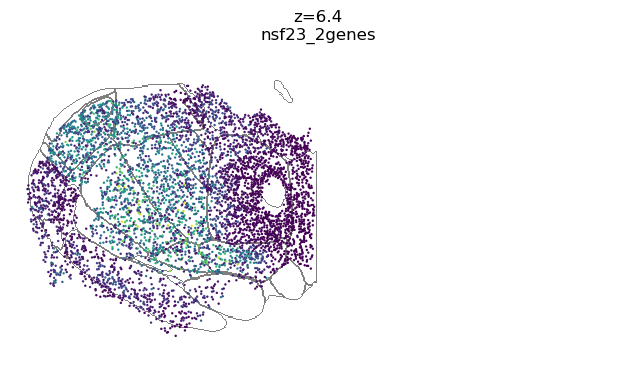

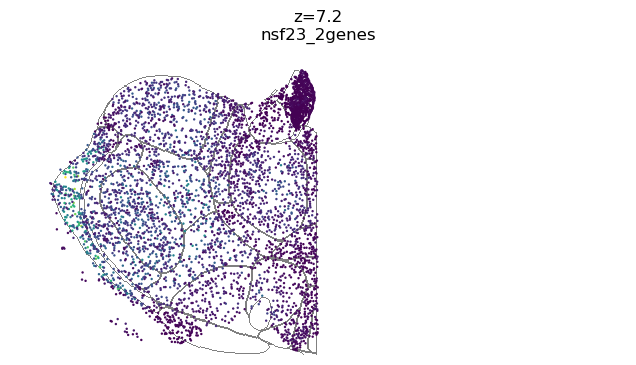

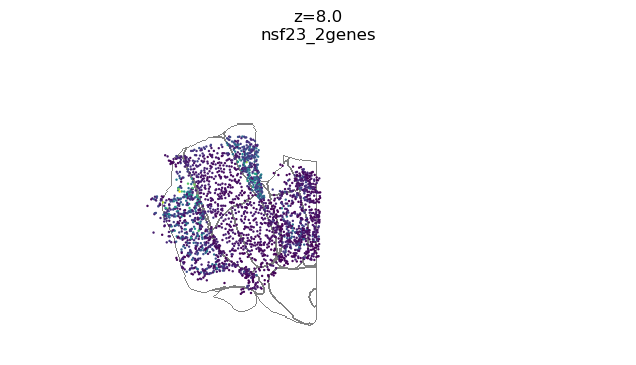

In [26]:
cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}_2genes', sections=sections_3,
                        shape_palette='dark_outline', 
                        point_palette='viridis', legend=None, 
                        section_col=section_col, 
                        x_col=x_coord_col, y_col=y_coord_col, s=3,
                        boundary_img=ccf_boundaries);

## plotting (nonlin alignment)

In [27]:
ccf_polygons2 = abc.get_ccf_labels_image(resampled=True, realigned=False)
# erase right hemisphere
ccf_polygons2[550:,:,:] = 0
ccf_boundaries2 = cimg.sectionwise_label_erosion(ccf_polygons2, distance_px=1, fill_val=0, return_edges=True)

In [28]:

ccf_label = 'parcellation_substructure'

x_coord_col = 'x_reconstructed'
y_coord_col = 'y_reconstructed'


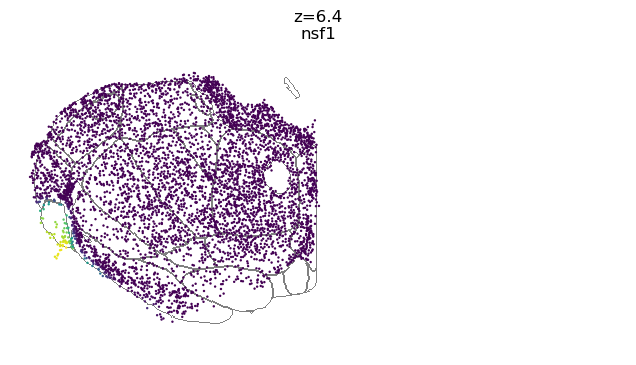

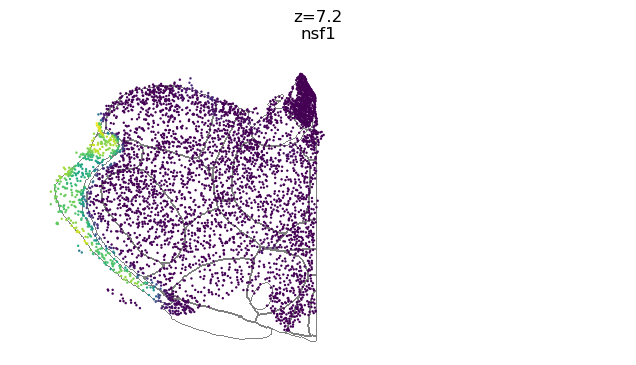

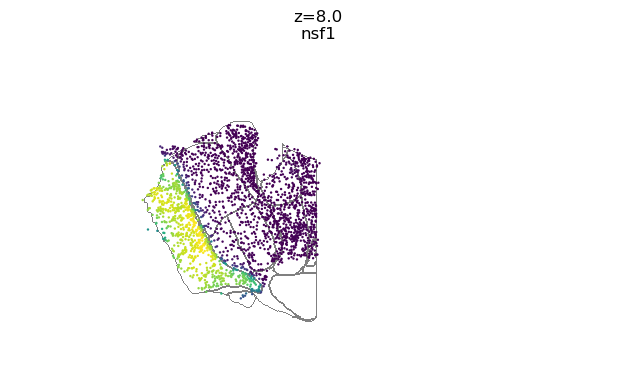

In [29]:
cplots.plot_ccf_overlay(obs, ccf_polygons2, categorical=False,
                        point_hue='nsf1', sections=sections_3,
                        shape_palette='dark_outline', 
                        point_palette='viridis', legend=None, 
                        section_col=section_col, 
                        x_col=x_coord_col, y_col=y_coord_col, s=3,
                        boundary_img=ccf_boundaries2);